## Mercari Price Suggestion

This notebook runs through our code for the Mercari Price Suggestion challenge, to suggest prices of products on the Mercari Marketplace.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import gc

import re
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from scipy.sparse import hstack

pd.options.display.max_columns = None

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test2.csv')

#train.drop('train_id', axis=1, inplace=True)
#test.drop('test_id', axis=1, inplace=True)

In [3]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [5]:
# Checking the size of the training and test dataset
print(train.shape)
print(test.shape)

(1482535, 7)
(3460725, 6)


In [6]:
# Checking the different data types in the dataset
train.dtypes

name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

### Price

In [7]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

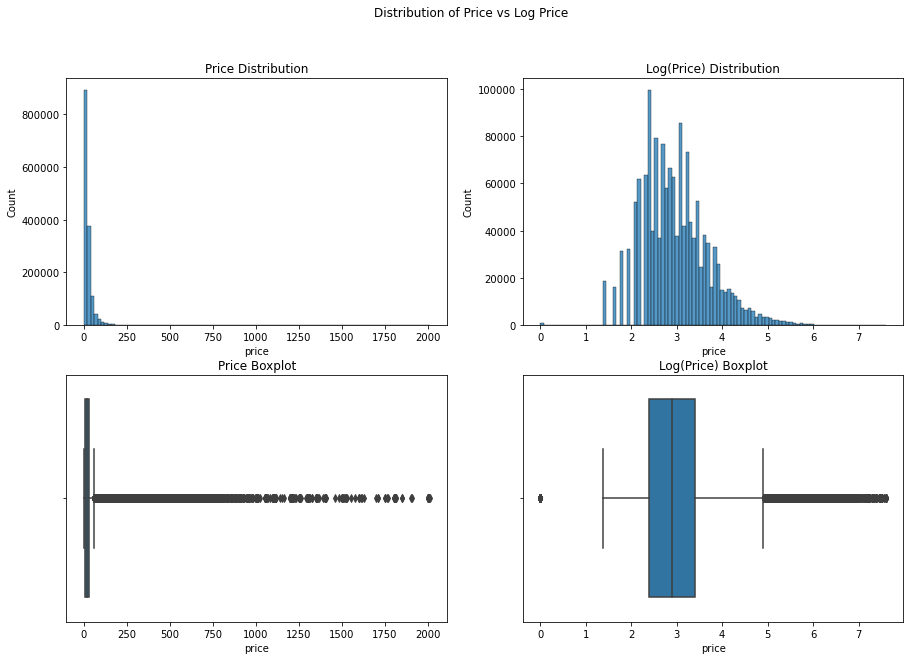

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle("Distribution of Price vs Log Price")
ax1 = sns.histplot(train['price'], bins=100, ax=ax[0, 0])
ax2 = sns.histplot(np.log1p(train['price']), bins=100, ax=ax[0, 1])
ax3 = sns.boxplot(x=train['price'], ax=ax[1, 0])
ax4 = sns.boxplot(x=np.log1p(train['price']), ax=ax[1, 1])

ax1.title.set_text('Price Distribution')
ax2.title.set_text('Log(Price) Distribution')
ax3.title.set_text('Price Boxplot')
ax4.title.set_text('Log(Price) Boxplot')

plt.show()

As the original price has such a skewed distribution, taking the logarithm of the price assists to create a normal distribution - so this is what I will be using.

In [9]:
train['price'] = np.log1p(train['price'])

### Categories

In [10]:
def split_cat(text):
    """Function to split the category_name column and deal with nulls"""
    try:
        return text.split("/")
    except:
        return ("No Label", "No Label", "No Label")

In [11]:
train['category_name'] = train.category_name.apply(lambda x: split_cat(x))
test['category_name'] = test.category_name.apply(lambda x: split_cat(x))

In [12]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",NaN,2.397895,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",Razer,3.970292,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",Target,2.397895,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",NaN,3.806662,0,Complete with certificate of authenticity


In [13]:
# Making 3 Seperate Columns for the 3 categories

# general category
train['general_category'] = train['category_name'].apply(lambda x: x[0])
# sub-category 1
train['sub_category1'] = train['category_name'].apply(lambda x: x[1])
# sub-category 2
train['sub_category2'] = train['category_name'].apply(lambda x: x[2])
train.drop('category_name', axis=1, inplace=True)

In [14]:
# general category
test['general_category'] = test['category_name'].apply(lambda x: x[0])
# sub-category 1
test['sub_category1'] = test['category_name'].apply(lambda x: x[1])
# sub-category 2
test['sub_category2'] = test['category_name'].apply(lambda x: x[2])
test.drop('category_name', axis=1, inplace=True)

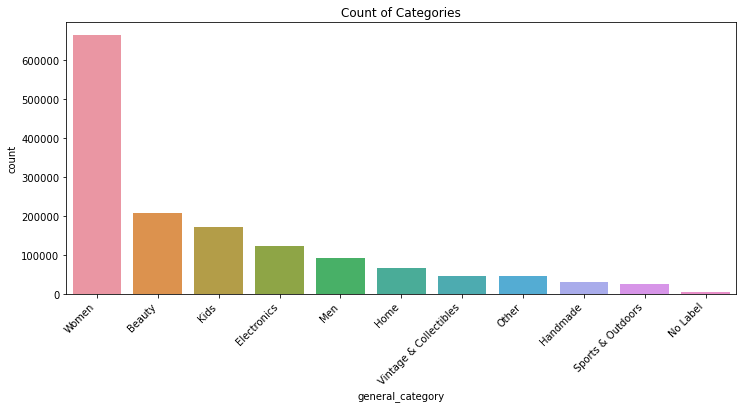

In [15]:
plt.figure(figsize=(12, 5))
sns.countplot(x=train['general_category'],
             order=train['general_category'].value_counts().index)
plt.title('Count of Categories')
plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight ='light',
          )
#plt.savefig('TopCats.jpg', bbox_inches="tight")
plt.show()

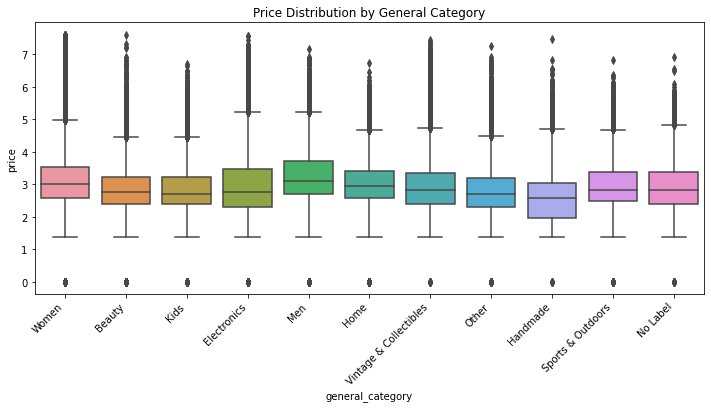

In [16]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=train, x='general_category', y='price', order=train['general_category'].value_counts().index)
plt.title('Price Distribution by General Category')
plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight ='light',
          )
#plt.savefig('PriceCats.jpg', bbox_inches="tight")
plt.show()

### Brand Names

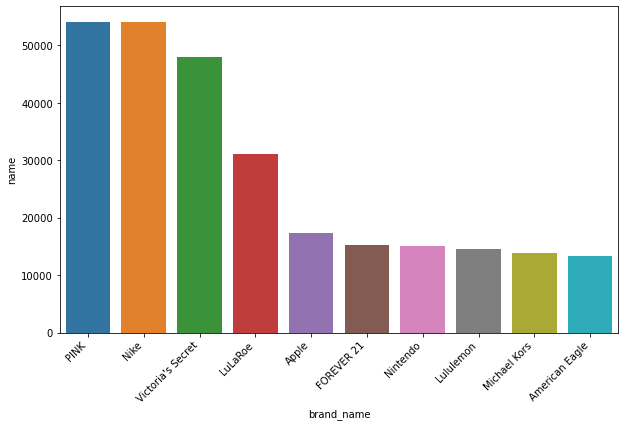

In [17]:
brand_df = train.groupby(['brand_name'])['name'].count().sort_values(ascending = False).head(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x =brand_df['brand_name'],
            y=brand_df['name'])
plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight ='light',
          )
plt.show()

### Item Condition

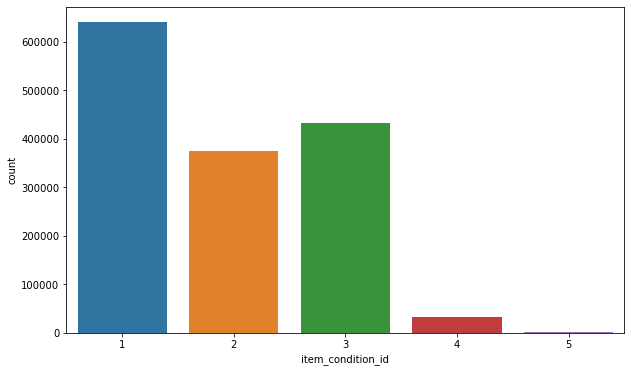

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x=train['item_condition_id'])
plt.show()

In [19]:
# Attempting to fill the missing brand names using the name of the product

# Making all columns lower case for uniformity
train['name'] = train.name.str.lower()
train['brand_name'] = train.brand_name.str.lower()
test['name'] = test.name.str.lower()
test['brand_name'] = test.brand_name.str.lower()

# Building a full list of brands
full_set = pd.concat([train,test])
all_brands = set(full_set['brand_name'].values)

# Filling the null brands with 'missing'
train.brand_name.fillna(value="missing", inplace=True)
test.brand_name.fillna(value="missing", inplace=True)

In [20]:
def brandfinder(brand_and_name):
    brand = brand_and_name[0]
    name = brand_and_name[1]
    namesplit = name.split(' ')
    if brand == 'missing':
        for x in namesplit:
            if x in all_brands:
                return name
    if name in all_brands:
        return name
    return brand

In [21]:
premissing = len(train.loc[train['brand_name'] == 'missing'])
train['brand_name'] = train[['brand_name','name']].apply(brandfinder, axis = 1)
test['brand_name'] = test[['brand_name','name']].apply(brandfinder, axis = 1)
found = premissing-len(train.loc[train['brand_name'] == 'missing'])
print(f'Filled {found} missing values.')

Filled 250910 missing values.


In [22]:
# Filling Null Descriptions with missing
train['item_description'].fillna('missing', inplace=True)

test['item_description'].fillna('missing', inplace=True)

In [23]:
train.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_category1,sub_category2
0,mlb cincinnati reds t shirt size xl,3,mlb cincinnati reds t shirt size xl,2.397895,1,No description yet,Men,Tops,T-shirts
1,razer blackwidow chroma keyboard,3,razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,ava-viv blouse,1,target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,leather horse statues,1,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24k gold plated rose,1,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


### Pre-processing: Tf-idf

Tf-idf is the acronym for Term Frequency–inverse Document Frequency. It quantifies the importance of a particular word in relative to the vocabulary of a collection of documents or corpus. The metric depends on two factors:

- Term Frequency: the occurences of a word in a given document (i.e. bag of words)
- Inverse Document Frequency: the reciprocal number of times a word occurs in a corpus of documents

If the word is used extensively in all documents, its existence within a specific document will not be able to provide us much specific information about the document itself. Tf-idf can therefore, be seen as a weighting scheme for words relevancy in a specific document.

In [24]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.
    Steps :
    - Removing punctuation
    - Lowering text
    """

    # remove the characters [\], ['] and ["] using the resub method:
    text = re.sub(r'\\', '', text)
    text = re.sub(r'\"', '', text)   
    text = re.sub(r'\'', '', text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

def tfidf(col, ngram):
    """Applies the Tf-idf Vectorizer to the specified column."""
    tfidf = TfidfVectorizer(stop_words="english",
                           preprocessor=clean_text,
                           ngram_range=ngram)
    traintfidf = tfidf.fit_transform(train[col])
    testtfidf = tfidf.transform(test[col])
    
    return traintfidf, testtfidf

In [25]:
# Applying the Tf-idf Vectorizer to the name, brand name and item description columns

train_brand, test_brand = tfidf('brand_name', (1, 2))
train_des, test_des = tfidf('item_description', (1, 2))
train_name, test_name = tfidf('name', (1, 2))

In [26]:
def labelbinarizer(col):
    """Applies Label Binarizer to the specified column"""
    lb = LabelBinarizer(sparse_output=True)
    trainrestultcol = lb.fit_transform(train[col])
    testrestultscol = lb.transform(test[col])
    
    return trainrestultcol, testrestultscol

In [27]:
# Applying the label binarizer to the categories, shipping and item condition

train_cat_1, test_cat_1 = labelbinarizer('general_category')
train_cat_2, test_cat_2 = labelbinarizer('sub_category1')
train_subcat_2, test_subcat_2 = labelbinarizer('sub_category2')
train_shipping, test_shipping = labelbinarizer('shipping')
train_condition, test_condition = labelbinarizer('item_condition_id')

In [28]:
# Merging all the features into one

train_features = (train_des, train_brand, train_name, train_cat_1, train_cat_2, 
                  train_subcat_2, train_shipping, train_condition)

train_features = hstack(train_features).tocsr()

del train_des, train_brand, train_name, train_cat_1, train_cat_2, train_subcat_2, train_shipping, train_condition

test_features = (test_des, test_brand, test_name, test_cat_1, test_cat_2, 
                  test_subcat_2, test_shipping, test_condition)

test_features = hstack(test_features).tocsr()

del test_name, test_des, test_brand, test_cat_1, test_cat_2, test_subcat_2, test_shipping, test_condition

### Evaluation Metric

We will evaluate our results using Root Mean Squared Log Error (RMSLE) as shown below:

$\sqrt{ \frac{1}{n} \sum \limits _{i=1} ^{n} (log(y_{i} + 1) - \hat{(y_{i}}+1))^2}$

In [29]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate(y, y_pred):
    return rmsle(np.expm1(y), np.expm1(y_pred))

### Training and Testing

In [31]:
X = train_features
y = train['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#### Ridge Regression

In [32]:
ridge = Ridge(solver='auto', fit_intercept=True, alpha=4.2, max_iter=200)
%time ridge.fit(X_train, y_train)

rmsle_Ridge = evaluate(y_test, ridge.predict(X_test))
print(f'RMSLE Ridge: {rmsle_Ridge}')

Wall time: 14min 16s
RMSLE Ridge: 0.4467855042277821


####  Linear Regression

In [33]:
SGD = SGDRegressor(loss="squared_loss",alpha=1e-8,fit_intercept=True)
%time SGD.fit(X_train, y_train)

rmsle_SGD = evaluate(y_test, SGD.predict(X_test))
print(f'RMSLE SGD: {rmsle_SGD}')

Wall time: 20.4 s
RMSLE SGD: 0.5179761848091751


#### Support Vector Regression

In [34]:
SVR = SGDRegressor(loss="epsilon_insensitive",alpha = 0.000001,fit_intercept=True)
%time SVR.fit(X_train, y_train)

rmsle_SVR = evaluate(y_test, SVR.predict(X_test))
print(f'RMSLE SVR: {rmsle_SVR}')

Wall time: 23.9 s
RMSLE SVR: 0.509244450496683


Although the Ridge Regressor took the longest, it had (by 0.05) the lowest RMSLE. The additional computational time is therefore worth it, and will be the choice of the final model.

### Preparing the Final Submission

In [35]:
X_test = test_features
preds = ridge.predict(X_test)
preds

array([2.35357089, 2.39297032, 3.98685492, ..., 2.79585485, 3.00734183,
       3.12866511])

In [36]:
submission = pd.DataFrame(np.exp(preds))
submission.reset_index(inplace=True)
submission.columns = ['test_id', 'price']
submission.head()

,test_id,price
0,0,10.523079
1,1,10.945959
2,2,53.885149
3,3,14.307272
4,4,9.162278


In [ ]:
#submission.to_csv('submission.csv', index=False)